# Notebook Title - Anomaly Detection using Autoencoders

In this notebook, we will explore using Autoencoders for Anomaly Detection in Time Series Data.

We will use Real Traffic Travel Time Dataset from Numenta Anomaly Benchmark - https://www.kaggle.com/datasets/boltzmannbrain/nab. The dataset is located at data/TravelTime_387.csv

First we will do EDA to determine distribution of Travel Times and a threshold to define a data point as an anomaly.

Next we will define the anomaly. For analysis, we will consider a window of 64 samples and consider the window to be an anomaly if the window has more than 4 anomalies. Using EDA, we can see that such a count gives us 10% of total windows to be anomalous.

Next, we will use different Autoencoder models and train them using a custom training loop. For evaluation we will consider the MSE between input and reconstructed output of anomalous and non anomalous samples.

We will consider the following AutoEncoder Architectures:

1) Dense Autoencoder

2) LSTM Autoencoder

3) Dense-LSTM Autoencoder

4) Dense-LSTM Autoencoder with tuned hyperparameters

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import datetime
import pickle
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install torchsummary
from torchsummary import summary

In [3]:
!pip install torchinfo
import torchinfo

In [4]:
df = pd.read_csv('data/TravelTime_387.csv')

In [5]:
df.head()

,timestamp,value
0,2015-07-10 14:24:00,564
1,2015-07-10 14:38:00,730
2,2015-07-10 14:48:00,770
3,2015-07-10 15:03:00,910
4,2015-07-10 15:22:00,1035


In [6]:
df.describe()

,value
count,2500.000000
mean,325.093600
std,399.555124
min,9.000000
25%,133.000000
50%,201.000000
75%,366.000000
max,5059.000000


In [7]:
df.shape

(2500, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2500 non-null   object
 1   value      2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB


In [9]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(2500, 2)

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
df.head()

,timestamp,value
0,2015-07-10 14:24:00,564
1,2015-07-10 14:38:00,730
2,2015-07-10 14:48:00,770
3,2015-07-10 15:03:00,910
4,2015-07-10 15:22:00,1035


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2500 non-null   datetime64[ns]
 1   value      2500 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 39.2 KB


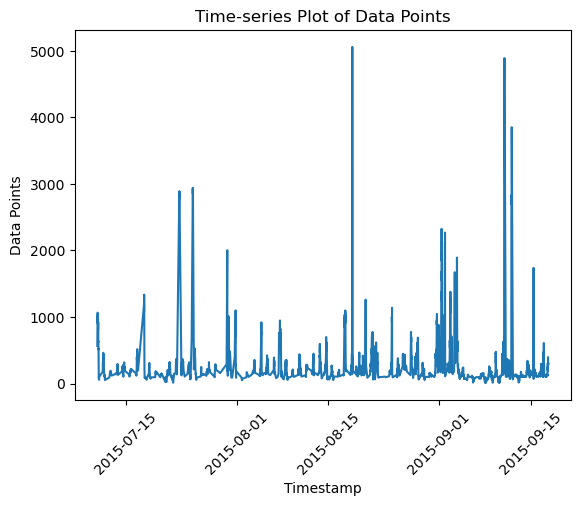

In [15]:
plt.plot(df['timestamp'], df['value'])
plt.xlabel('Timestamp')
plt.ylabel('Data Points')
plt.title('Time-series Plot of Data Points')
plt.xticks(rotation=45)
plt.show()

In [16]:
bins = [float('-inf'), 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, float('inf')]
bin_labels = ['0', '(0,500]', '(500,1000]', '(1000,1500]', '(1500,2000]', '(2000,2500]', '(2500,3000]', '(3000,3500]', '(3500, inf)']
df['value_range'] = pd.cut(df['value'], bins=bins, labels=bin_labels, right=True)
counts = df['value_range'].value_counts().sort_index()

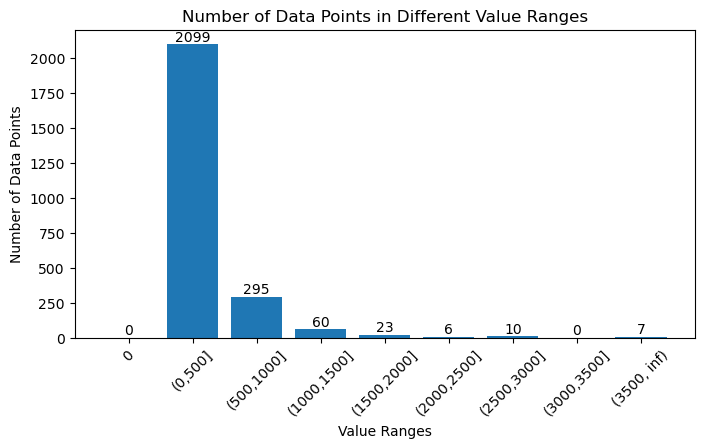

In [17]:
plt.figure(figsize=(8, 4))
plt.bar(counts.index, counts.values)
plt.xlabel('Value Ranges')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Different Value Ranges')
plt.xticks(rotation=45)
for i, count in enumerate(counts.values):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')
plt.show()

In [18]:
df.drop(columns = ['value_range'], inplace = True)

In [19]:
data = df['value'].to_numpy()

In [20]:
data.shape

(2500,)

In [21]:
windowlen = 64
stride = 1  

num_windows = (len(data) - windowlen) // stride + 1

data_windows = np.zeros((num_windows, windowlen))

for i in range(num_windows):
    data_windows[i] = data[i * stride: i * stride + windowlen]

In [92]:
print(data_windows.shape)

(2437, 64)


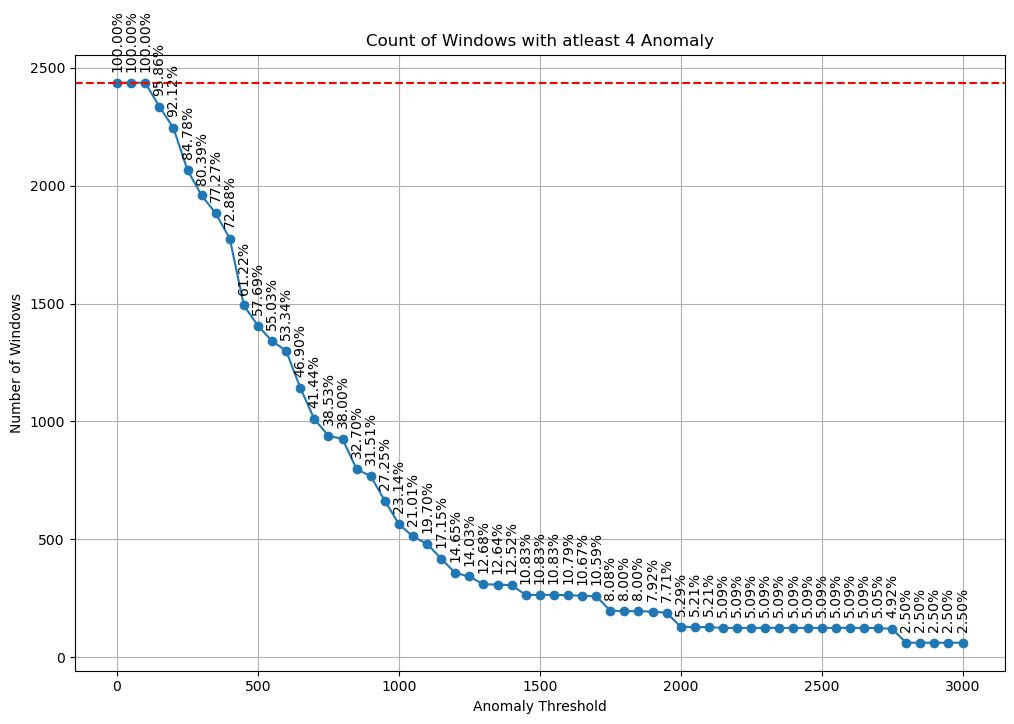

In [22]:
threshold_values = np.arange(0, 3005, 50)

anomalous_count_vs_threshold = []
mincount = 4

for thres in threshold_values:
    anomalous_windows = np.sum(data_windows > thres, axis=1) >= mincount
    num_anomalous_windows = np.sum(anomalous_windows)
    anomalous_count_vs_threshold.append(num_anomalous_windows)

plt.figure(figsize=(12, 8))
plt.plot(threshold_values, anomalous_count_vs_threshold, marker='o')
plt.axhline(y=len(data_windows), color='r', linestyle='--', label='Total Samples in Windows')
plt.xlabel('Anomaly Threshold')
plt.ylabel('Number of Windows')
plt.title(f'Count of Windows with atleast {mincount} Anomaly')
plt.grid(True)

for thres, count in zip(threshold_values, anomalous_count_vs_threshold):
    percentage = (count / len(data_windows)) * 100
    plt.annotate(f'{percentage:.2f}%', xy=(thres, count), xytext=(-5, 10), textcoords='offset points', rotation=90)

plt.show()

In [23]:
non_anomalous_windows = []
anomalous_windows = []

thres = 1500

for window in data_windows:
    if np.sum(window > thres) >= mincount:
        anomalous_windows.append(window)
    else:
        non_anomalous_windows.append(window)

# Convert lists to numpy arrays
non_anomalous_windows = np.array(non_anomalous_windows)
anomalous_windows = np.array(anomalous_windows)

In [24]:
print(non_anomalous_windows.shape)

(2173, 64)


In [25]:
print(anomalous_windows.shape)

(264, 64)


In [26]:
# Define proportions for train, validation, and test sets
train_proportion = 0.673
valid_proportion = 0.225
test_proportion = 0.102

non_anomalous_count = len(non_anomalous_windows)
anomalous_count = len(anomalous_windows)

train_count = int(train_proportion * non_anomalous_count)
valid_count = int(valid_proportion * non_anomalous_count)

np.random.shuffle(non_anomalous_windows)
np.random.shuffle(anomalous_windows)

train_set = non_anomalous_windows[:train_count]
valid_set = non_anomalous_windows[train_count:train_count+valid_count]
test_set_non_anomalous = non_anomalous_windows[train_count+valid_count:]

test_set = np.concatenate((test_set_non_anomalous, anomalous_windows), axis=0)

In [27]:
train_set_shape = train_set.shape
print(f"Train Dataset shape {train_set.shape} Percentage of Total Dataset = {round(train_set_shape[0] / num_windows * 100.0, 2)} Percent")

Train Dataset shape (1462, 64) Percentage of Total Dataset = 59.99 Percent


In [28]:
valid_set_shape = valid_set.shape
print(f"Validation Dataset shape {valid_set.shape} Percentage of Total Dataset = {round(valid_set_shape[0] / num_windows * 100.0, 2)} Percent")

Validation Dataset shape (488, 64) Percentage of Total Dataset = 20.02 Percent


In [29]:
test_set_shape = test_set.shape
print(f"Test Dataset shape {test_set.shape} Percentage of Total Dataset = {round(test_set_shape[0] / num_windows * 100.0, 2)} Percent")

Test Dataset shape (487, 64) Percentage of Total Dataset = 19.98 Percent


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32).to(device), torch.tensor(self.data[idx], dtype=torch.float32).to(device)

In [32]:
scaler = MinMaxScaler()
scaler.fit(train_set)

MinMaxScaler()

In [93]:
# Print properties of the scaler
print("Data Range (min, max):", scaler.data_min_, scaler.data_max_)
print("Scale (min, max):", scaler.min_, scaler.scale_)
print("Number of Samples Seen:", scaler.n_samples_seen_)
print("Data Range:", scaler.data_range_)

Data Range (min, max): [12. 12. 11. 11. 11. 11. 11. 12. 12. 11. 12. 11. 11. 11. 12. 11. 12. 11.
 12. 11. 11. 11. 12. 12. 12. 11. 10.  9. 12. 10.  9. 10.  9.  9. 10.  9.
  9.  9.  9.  9. 10.  9.  9. 10.  9.  9.  9.  9. 11. 11. 10.  9.  9.  9.
 10.  9. 11. 10.  9.  9.  9.  9.  9.  9.] [5059. 5059. 5059. 5059. 5059. 2941. 2858. 2941. 5059. 5059. 2924. 5059.
 2941. 5059. 5059. 2924. 2941. 5059. 5059. 5059. 5059. 5059. 5059. 5059.
 5059. 2924. 5059. 2941. 5059. 5059. 2941. 5059. 5059. 5059. 5059. 5059.
 5059. 5059. 5059. 5059. 5059. 5059. 5059. 2891. 5059. 5059. 5059. 5059.
 5059. 5059. 5059. 5059. 5059. 5059. 2924. 5059. 5059. 5059. 2941. 5059.
 5059. 5059. 4562. 4891.]
Scale (min, max): [-0.00237765 -0.00237765 -0.00217908 -0.00217908 -0.00217908 -0.00375427
 -0.00386372 -0.00409696 -0.00237765 -0.00217908 -0.00412088 -0.00217908
 -0.00375427 -0.00217908 -0.00237765 -0.00377618 -0.00409696 -0.00217908
 -0.00237765 -0.00217908 -0.00217908 -0.00217908 -0.00237765 -0.00237765
 -0.00237765 -0

In [33]:
# Convert the three datasets into custom datasets
train_dataset = CustomDataset(scaler.transform(train_set))
valid_dataset = CustomDataset(scaler.transform(valid_set))
test_dataset = CustomDataset(scaler.transform(test_set))

In [34]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [35]:
train_dataset_size = len(train_loader.dataset)
test_dataset_size = len(test_loader.dataset)
validation_dataset_size = len(valid_loader.dataset)

print("Train Dataset Size : {}".format(train_dataset_size))
print("Validation Dataset Size : {}".format(validation_dataset_size))
print("Test Dataset Size : {}".format(test_dataset_size))

Train Dataset Size : 1462
Validation Dataset Size : 488
Test Dataset Size : 487


In [36]:
class ModelTrial():
    def __init__(self, model, criterion, optimizer, threshold, mincount, scheduler, scaler, l1_lambda = 0, has_lstm = False):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_metrics = {'loss': []}
        self.validation_metrics = {'loss': []}
        self.test_metrics = {'loss': []}
        self.train_time = None
        self.epochs = []
        self.test_outputs = {}
        self.l1_lambda = l1_lambda
        self.thres = threshold
        self.mincount = mincount
        self.has_lstm = has_lstm
        self.scaler = scaler
    def printModel(self):
        print(self.model)
    def printModelSummary(self, input_size):
        print(torchinfo.summary(self.model, input_size = input_size))
    def trainingLoop(self, trainLoader, validationLoader, num_epochs, temp_model_path, final_model_path, trial_save_path, verbose = True, lr_scheduler = True, early_stop = True, patience = 10):
        self.train_metrics = {'loss': []}
        self.validation_metrics = {'loss': []}
        self.test_metrics = {'loss': []}
        self.test_outputs = {}
        self.epochs = range(1, num_epochs+1)
        cumulative_train_time = datetime.timedelta()
        min_validation_loss = float('inf')
        patience_ctr = 0
        break_epoch = self.epochs[-1]
        for epoch in self.epochs:
            print(f"In Epoch {epoch}")
            training_loss = 0.0
            t1 = datetime.datetime.now()
            self.model.train()
            for batch_idx, batch_data in enumerate(tqdm(trainLoader)):
                if self.has_lstm:
                    inputs = batch_data[0].unsqueeze(dim=-1)
                    labels = batch_data[1].unsqueeze(dim=-1)
                else:   
                    inputs = batch_data[0]
                    labels = batch_data[1]
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                if self.l1_lambda:
                    l1_reg = torch.tensor(0., requires_grad=True)
                    for param in self.model.parameters():
                        l1_reg = l1_reg + torch.norm(param, 1)
                    loss = loss + self.l1_lambda * l1_reg

                loss.backward()
                self.optimizer.step()
                training_loss += loss.item() / (train_dataset_size / trainLoader.batch_size)

            t2 = datetime.datetime.now()
            cumulative_train_time += t2-t1

            if verbose:
                print(f"Epoch {epoch}, Training Loss: {training_loss:.5f}")
            self.train_metrics['loss'].append(training_loss)
            # Validation loop
            validation_loss = 0.0
            self.model.eval()
            with torch.no_grad():  # Disable gradient computation
                for batch_idx, batch_data in enumerate(tqdm(validationLoader)):
                    if self.has_lstm:
                        inputs = batch_data[0].unsqueeze(dim=-1)
                        labels = batch_data[1].unsqueeze(dim=-1)
                    else:   
                        inputs = batch_data[0]
                        labels = batch_data[1]
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    validation_loss += loss.item() / (validation_dataset_size / validationLoader.batch_size)

                if verbose:
                    print(f"Epoch {epoch}, Validation Loss: {validation_loss:.5f}")
                self.validation_metrics['loss'].append(validation_loss)
            if lr_scheduler:
                self.scheduler.step(validation_loss)
            if early_stop:
                if validation_loss <= min_validation_loss:
                    min_validation_loss = validation_loss
                    patience_counter = 0
                    self.saveModel(temp_model_path)
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("\nEarly stopping")
                        break_epoch = epoch
                        self.loadModel(temp_model_path)
                        break
        self.epochs = self.epochs[:break_epoch]
        self.train_time = cumulative_train_time
        print("Training Ended !!!")
        self.saveModel(final_model_path)
        self.saveTrial(trial_save_path)

    def testDatasetPass(self, testLoader):
        self.model.eval()
        test_loss = 0.0
        test_labels = torch.Tensor([]).to(device)
        test_outputs = torch.Tensor([]).to(device)
        print(f"Testing Started!")
        with torch.no_grad():
            for batch_idx, batch_data in enumerate(tqdm(testLoader)):
                if self.has_lstm:
                    inputs = batch_data[0].unsqueeze(dim=-1)
                    labels = batch_data[1].unsqueeze(dim=-1)
                else:   
                    inputs = batch_data[0]
                    labels = batch_data[1]
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() / (test_dataset_size / testLoader.batch_size)
                if self.has_lstm:
                    labels = labels.squeeze(dim = -1)
                    outputs = outputs.squeeze(dim = -1)
                test_labels = torch.cat((test_labels,labels),dim = 0)
                test_outputs = torch.cat((test_outputs,outputs), dim = 0)

        self.test_metrics['loss'] = [test_loss]*(len(self.epochs))
        
        labels_np = test_labels.detach().numpy()
        outputs_np = test_outputs.detach().numpy()

        labels_np = self.scaler.inverse_transform(labels_np)
        outputs_np = self.scaler.inverse_transform(outputs_np)

        labels_tensor = torch.tensor(labels_np).to(device)
        outputs_tensor = torch.tensor(outputs_np).to(device)

        self.test_outputs['labels'] = labels_tensor
        self.test_outputs['outputs'] = outputs_tensor
    
        print(f"Testing Completed!!")
        print(f"Testing Loss: {test_loss:.5f}")

    def printTrainTimeStatistics(self):
        print("Time taken to train model (train phase alone considered) is : ")
        days = self.train_time.days
        seconds = self.train_time.seconds
        microseconds = self.train_time.microseconds
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Days: {days}, Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Microseconds: {microseconds}")

    def plotLossVsEpochs(self):
        fig = plt.figure()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.plot(self.epochs, self.test_metrics['loss'], label = 'Test')
        plt.plot(self.epochs, self.validation_metrics['loss'], label = 'Validation')
        plt.plot(self.epochs, self.train_metrics['loss'], label = 'Train')

        plt.title('Loss vs Epochs graph for Train, Test and Validation Dataset')
        plt.legend()
        plt.show()
        
    def plotTestDatasetMSEHistogram(self):
        mse = torch.mean((self.test_outputs['labels'] - self.test_outputs['outputs'])**2, dim=1).detach().numpy()
        thres_tensor = torch.tensor(self.thres)

        is_anomalous = torch.sum(self.test_outputs['labels'] > thres, dim=1) >= self.mincount
        
        anomalous_mse = mse[is_anomalous.numpy()]
        non_anomalous_mse = mse[~is_anomalous.numpy()]

        fig, axes = plt.subplots(2, 1, figsize=(10, 8))

        axes[0].hist(anomalous_mse, bins=50, alpha=0.5, color='red', label='Anomalous (Original)', density=False)
        axes[0].hist(non_anomalous_mse, bins=50, alpha=0.5, color='blue', label='Non-Anomalous (Original)', density=False)
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Original MSE Histogram for Test Dataset')
        axes[0].legend()

        axes[1].hist(anomalous_mse, bins=50, alpha=0.5, color='red', label='Anomalous (Normalized)', density=True)
        axes[1].hist(non_anomalous_mse, bins=50, alpha=0.5, color='blue', label='Non-Anomalous (Normalized)', density=True)
        axes[1].set_xlabel('Mean Squared Error (MSE)')
        axes[1].set_ylabel('Normalized Frequency')
        axes[1].set_title('Normalized MSE Histogram for Test Dataset')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def saveModel(self, path):
        torch.save(self.model.state_dict(), path)

    def loadModel(self, path):
        loadedModel = torch.load(path)
        self.model.load_state_dict(loadedModel)

    def saveTrial(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    def loadTrial(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)

## Dense Autoencoder 

In [37]:
lr=0.01
num_epochs = 40
l1_lambda = 0
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0
hidden_size = 4
threshold = thres
has_lstm = False
mincount = mincount
scaler = scaler
temp_model_path = 'content/autoencoder/dense_temp.pth'
final_model_path = 'content/autoencoder/dense.pth'
trial_save_path = 'content/autoencoder/dense.pkl'

In [38]:
class DenseAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0):
        super(DenseAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size*8),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size*8, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size*4, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size*4, hidden_size*8),
            nn.ReLU(),
            nn.Dropout(dropout), 
            nn.Linear(hidden_size*8, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:
baseAutoEncoder = DenseAutoEncoder(input_size=windowlen,
                      hidden_size=hidden_size,
                      dropout=dropoutProb)
criterion = nn.MSELoss()
optimizer = optim.Adam(baseAutoEncoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [40]:
baseAutoEncoderModel = ModelTrial(baseAutoEncoder, criterion, optimizer, threshold, mincount, scheduler = scheduler, scaler = scaler, l1_lambda = l1_lambda, has_lstm=has_lstm)

In [41]:
baseAutoEncoderModel.printModel()

DenseAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=16, out_features=4, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=32, out_features=64, bias=True)
  )
)


In [42]:
baseAutoEncoderModel.printModelSummary((64, windowlen))

Layer (type:depth-idx)                   Output Shape              Param #
DenseAutoEncoder                         [64, 64]                  --
├─Sequential: 1-1                        [64, 4]                   --
│    └─Linear: 2-1                       [64, 32]                  2,080
│    └─ReLU: 2-2                         [64, 32]                  --
│    └─Dropout: 2-3                      [64, 32]                  --
│    └─Linear: 2-4                       [64, 16]                  528
│    └─ReLU: 2-5                         [64, 16]                  --
│    └─Dropout: 2-6                      [64, 16]                  --
│    └─Linear: 2-7                       [64, 4]                   68
│    └─ReLU: 2-8                         [64, 4]                   --
├─Sequential: 1-2                        [64, 64]                  --
│    └─Linear: 2-9                       [64, 16]                  80
│    └─ReLU: 2-10                        [64, 16]                  --
│    └─Drop

In [43]:
baseAutoEncoderModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 140.77it/s]


Epoch 1, Training Loss: 0.00680


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 561.36it/s]


Epoch 1, Validation Loss: 0.00561
In Epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.11it/s]


Epoch 2, Training Loss: 0.00469


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 598.91it/s]


Epoch 2, Validation Loss: 0.00524
In Epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 141.74it/s]


Epoch 3, Training Loss: 0.00415


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 540.63it/s]


Epoch 3, Validation Loss: 0.00433
In Epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 130.03it/s]


Epoch 4, Training Loss: 0.00345


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 671.05it/s]


Epoch 4, Validation Loss: 0.00408
In Epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 140.14it/s]


Epoch 5, Training Loss: 0.00329


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 577.60it/s]


Epoch 5, Validation Loss: 0.00387
In Epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 138.73it/s]


Epoch 6, Training Loss: 0.00325


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 585.85it/s]


Epoch 6, Validation Loss: 0.00384
In Epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 134.48it/s]


Epoch 7, Training Loss: 0.00321


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 638.26it/s]


Epoch 7, Validation Loss: 0.00382
In Epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 132.74it/s]


Epoch 8, Training Loss: 0.00319


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 583.46it/s]


Epoch 8, Validation Loss: 0.00385
In Epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.86it/s]


Epoch 9, Training Loss: 0.00319


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 539.94it/s]


Epoch 9, Validation Loss: 0.00381
In Epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 141.93it/s]


Epoch 10, Training Loss: 0.00316


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 658.87it/s]


Epoch 10, Validation Loss: 0.00378
In Epoch 11


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 145.96it/s]


Epoch 11, Training Loss: 0.00311


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 551.54it/s]


Epoch 11, Validation Loss: 0.00376
In Epoch 12


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 145.02it/s]


Epoch 12, Training Loss: 0.00308


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 529.11it/s]


Epoch 12, Validation Loss: 0.00376
In Epoch 13


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 141.19it/s]


Epoch 13, Training Loss: 0.00307


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 602.93it/s]


Epoch 13, Validation Loss: 0.00374
In Epoch 14


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 139.86it/s]


Epoch 14, Training Loss: 0.00303


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 615.35it/s]


Epoch 14, Validation Loss: 0.00380
In Epoch 15


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 145.51it/s]


Epoch 15, Training Loss: 0.00299


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 535.15it/s]


Epoch 15, Validation Loss: 0.00367
In Epoch 16


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 154.88it/s]


Epoch 16, Training Loss: 0.00300


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 617.59it/s]


Epoch 16, Validation Loss: 0.00375
In Epoch 17


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 143.76it/s]


Epoch 17, Training Loss: 0.00296


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 589.08it/s]


Epoch 17, Validation Loss: 0.00368
In Epoch 18


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 147.26it/s]


Epoch 18, Training Loss: 0.00293


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 579.87it/s]


Epoch 18, Validation Loss: 0.00362
In Epoch 19


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 149.20it/s]


Epoch 19, Training Loss: 0.00292


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 660.47it/s]


Epoch 19, Validation Loss: 0.00366
In Epoch 20


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 155.10it/s]


Epoch 20, Training Loss: 0.00291


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 587.53it/s]


Epoch 20, Validation Loss: 0.00360
In Epoch 21


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 160.49it/s]


Epoch 21, Training Loss: 0.00289


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 609.81it/s]


Epoch 21, Validation Loss: 0.00359
In Epoch 22


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.35it/s]


Epoch 22, Training Loss: 0.00287


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 670.99it/s]


Epoch 22, Validation Loss: 0.00351
In Epoch 23


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 159.04it/s]


Epoch 23, Training Loss: 0.00284


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 666.19it/s]


Epoch 23, Validation Loss: 0.00354
In Epoch 24


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 139.62it/s]


Epoch 24, Training Loss: 0.00286


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 630.59it/s]


Epoch 24, Validation Loss: 0.00353
In Epoch 25


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 158.33it/s]


Epoch 25, Training Loss: 0.00283


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 578.05it/s]


Epoch 25, Validation Loss: 0.00358
In Epoch 26


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 152.51it/s]


Epoch 26, Training Loss: 0.00283


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 654.70it/s]


Epoch 26, Validation Loss: 0.00355
In Epoch 27


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.09it/s]


Epoch 27, Training Loss: 0.00283


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 612.90it/s]


Epoch 27, Validation Loss: 0.00354
In Epoch 28


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 150.64it/s]


Epoch 28, Training Loss: 0.00281


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 699.38it/s]


Epoch 28, Validation Loss: 0.00358
In Epoch 29


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 156.36it/s]


Epoch 29, Training Loss: 0.00279


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 635.56it/s]


Epoch 29, Validation Loss: 0.00354
In Epoch 30


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 142.38it/s]


Epoch 30, Training Loss: 0.00277


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 638.04it/s]


Epoch 30, Validation Loss: 0.00359
In Epoch 31


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 149.07it/s]


Epoch 31, Training Loss: 0.00277


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 512.66it/s]


Epoch 31, Validation Loss: 0.00346
In Epoch 32


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 136.88it/s]


Epoch 32, Training Loss: 0.00276


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 561.62it/s]


Epoch 32, Validation Loss: 0.00351
In Epoch 33


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 126.68it/s]


Epoch 33, Training Loss: 0.00276


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 496.37it/s]


Epoch 33, Validation Loss: 0.00344
In Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 94.85it/s]


Epoch 34, Training Loss: 0.00274


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 401.08it/s]


Epoch 34, Validation Loss: 0.00350
In Epoch 35


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 130.60it/s]


Epoch 35, Training Loss: 0.00275


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 554.82it/s]


Epoch 35, Validation Loss: 0.00339
In Epoch 36


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.07it/s]


Epoch 36, Training Loss: 0.00273


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 588.22it/s]


Epoch 36, Validation Loss: 0.00342
In Epoch 37


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 152.79it/s]


Epoch 37, Training Loss: 0.00271


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 566.74it/s]


Epoch 37, Validation Loss: 0.00341
In Epoch 38


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 143.00it/s]


Epoch 38, Training Loss: 0.00270


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 533.78it/s]


Epoch 38, Validation Loss: 0.00346
In Epoch 39


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 151.31it/s]


Epoch 39, Training Loss: 0.00269


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 571.35it/s]


Epoch 39, Validation Loss: 0.00338
In Epoch 40


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 148.40it/s]


Epoch 40, Training Loss: 0.00266


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 666.66it/s]

Epoch 40, Validation Loss: 0.00338
Training Ended !!!


In [44]:
baseAutoEncoderModel.testDatasetPass(test_loader)

Testing Started!


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 518.77it/s]

Testing Completed!!
Testing Loss: 0.01603


In [45]:
baseAutoEncoderModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 6, Microseconds: 630311


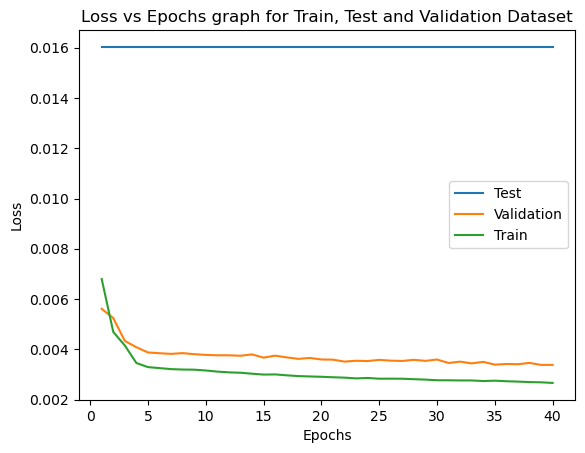

In [46]:
baseAutoEncoderModel.plotLossVsEpochs()

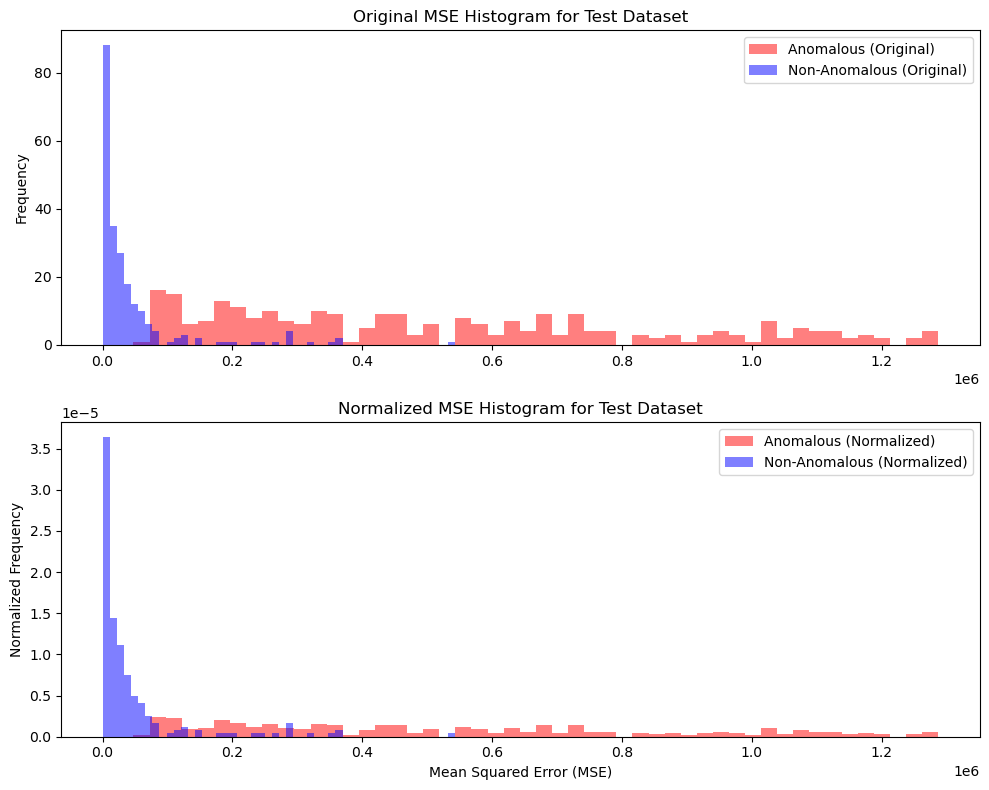

In [47]:
baseAutoEncoderModel.plotTestDatasetMSEHistogram()

## LSTM Autoencoder 

In [81]:
lr=0.01
num_epochs = 40
l1_lambda = 0
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0
rnn_hidden_size = 4
hidden_size = 4
input_size = 1
threshold = thres
has_lstm = True
mincount = mincount
recurrentDropoutProb = 0
num_layers = 3
scaler = scaler
temp_model_path = 'content/autoencoder/lstm_temp.pth'
final_model_path = 'content/autoencoder/lstm.pth'
trial_save_path = 'content/autoencoder/lstm.pkl'

In [82]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, windowlen, hidden_size, num_layers, dropout = 0, recurrent_dropout = 0):
        super(LSTMAutoEncoder, self).__init__()
        
        self.lstmencoder = nn.LSTM(input_size=input_size, 
                               hidden_size=rnn_hidden_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)

        self.lstmdecoder = nn.LSTM(input_size=rnn_hidden_size, 
                               hidden_size=input_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)

    def forward(self, x):
        x, (_, _) = self.lstmencoder(x)
        x, (_, _) = self.lstmdecoder(x)
        return x

In [83]:
lstmAutoEncoder = LSTMAutoEncoder(input_size=input_size,
                      hidden_size=hidden_size,
                      rnn_hidden_size=rnn_hidden_size,
                      windowlen = windowlen,
                      num_layers=num_layers,
                      dropout=dropoutProb,
                      recurrent_dropout=recurrentDropoutProb)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstmAutoEncoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [84]:
lstmAutoEncoderModel = ModelTrial(lstmAutoEncoder, criterion, optimizer, threshold, mincount, scheduler = scheduler, scaler = scaler, l1_lambda = l1_lambda, has_lstm=has_lstm)

In [85]:
lstmAutoEncoderModel.printModel()

LSTMAutoEncoder(
  (lstmencoder): LSTM(1, 4, num_layers=3, batch_first=True)
  (lstmdecoder): LSTM(4, 1, num_layers=3, batch_first=True)
)


In [86]:
lstmAutoEncoderModel.printModelSummary((64, windowlen, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoEncoder                          [64, 64, 1]               --
├─LSTM: 1-1                              [64, 64, 4]               432
├─LSTM: 1-2                              [64, 64, 1]               60
Total params: 492
Trainable params: 492
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.02
Input size (MB): 0.02
Forward/backward pass size (MB): 0.16
Params size (MB): 0.00
Estimated Total Size (MB): 0.18


In [87]:
lstmAutoEncoderModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.33it/s]


Epoch 1, Training Loss: 0.09790


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 176.07it/s]


Epoch 1, Validation Loss: 0.00693
In Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.14it/s]


Epoch 2, Training Loss: 0.00724


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 145.21it/s]


Epoch 2, Validation Loss: 0.00594
In Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.24it/s]


Epoch 3, Training Loss: 0.00505


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 185.98it/s]


Epoch 3, Validation Loss: 0.00579
In Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.35it/s]


Epoch 4, Training Loss: 0.00496


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 185.61it/s]


Epoch 4, Validation Loss: 0.00576
In Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.37it/s]


Epoch 5, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 190.64it/s]


Epoch 5, Validation Loss: 0.00569
In Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 25.69it/s]


Epoch 6, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 179.35it/s]


Epoch 6, Validation Loss: 0.00573
In Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.11it/s]


Epoch 7, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 134.29it/s]


Epoch 7, Validation Loss: 0.00567
In Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.57it/s]


Epoch 8, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 177.29it/s]


Epoch 8, Validation Loss: 0.00574
In Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.61it/s]


Epoch 9, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 174.20it/s]


Epoch 9, Validation Loss: 0.00571
In Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.16it/s]


Epoch 10, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 197.97it/s]


Epoch 10, Validation Loss: 0.00569
In Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.39it/s]


Epoch 11, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 199.07it/s]


Epoch 11, Validation Loss: 0.00569
In Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.91it/s]


Epoch 12, Training Loss: 0.00496


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 191.78it/s]


Epoch 12, Validation Loss: 0.00565
In Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.09it/s]


Epoch 13, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 180.08it/s]


Epoch 13, Validation Loss: 0.00567
In Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.98it/s]


Epoch 14, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 193.94it/s]


Epoch 14, Validation Loss: 0.00580
In Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.25it/s]


Epoch 15, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.90it/s]


Epoch 15, Validation Loss: 0.00582
In Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.90it/s]


Epoch 16, Training Loss: 0.00493


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 195.29it/s]


Epoch 16, Validation Loss: 0.00570
In Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.01it/s]


Epoch 17, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.24it/s]


Epoch 17, Validation Loss: 0.00580
In Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.60it/s]


Epoch 18, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 187.54it/s]


Epoch 18, Validation Loss: 0.00570
In Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.65it/s]


Epoch 19, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 174.96it/s]


Epoch 19, Validation Loss: 0.00568
In Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.71it/s]


Epoch 20, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 186.24it/s]


Epoch 20, Validation Loss: 0.00570
In Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.40it/s]


Epoch 21, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 172.63it/s]


Epoch 21, Validation Loss: 0.00570
In Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.77it/s]


Epoch 22, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 200.19it/s]


Epoch 22, Validation Loss: 0.00576
In Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.65it/s]


Epoch 23, Training Loss: 0.00493


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 189.72it/s]


Epoch 23, Validation Loss: 0.00570
In Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.02it/s]


Epoch 24, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 200.23it/s]


Epoch 24, Validation Loss: 0.00576
In Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.91it/s]


Epoch 25, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 124.30it/s]


Epoch 25, Validation Loss: 0.00570
In Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.40it/s]


Epoch 26, Training Loss: 0.00493


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 143.69it/s]


Epoch 26, Validation Loss: 0.00576
In Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.06it/s]


Epoch 27, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 110.73it/s]


Epoch 27, Validation Loss: 0.00571
In Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.99it/s]


Epoch 28, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 188.92it/s]


Epoch 28, Validation Loss: 0.00572
In Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.01it/s]


Epoch 29, Training Loss: 0.00493


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 185.94it/s]


Epoch 29, Validation Loss: 0.00568
In Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.67it/s]


Epoch 30, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 180.14it/s]


Epoch 30, Validation Loss: 0.00566
In Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.46it/s]


Epoch 31, Training Loss: 0.00495


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 179.97it/s]


Epoch 31, Validation Loss: 0.00565
In Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.17it/s]


Epoch 32, Training Loss: 0.00493


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 173.33it/s]


Epoch 32, Validation Loss: 0.00571
In Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.20it/s]


Epoch 33, Training Loss: 0.00492


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 191.33it/s]


Epoch 33, Validation Loss: 0.00566
In Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.67it/s]


Epoch 34, Training Loss: 0.00492


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 182.73it/s]


Epoch 34, Validation Loss: 0.00566
In Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.66it/s]


Epoch 35, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.29it/s]


Epoch 35, Validation Loss: 0.00572
In Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.04it/s]


Epoch 36, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 187.37it/s]


Epoch 36, Validation Loss: 0.00567
In Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.79it/s]


Epoch 37, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 176.85it/s]


Epoch 37, Validation Loss: 0.00578
In Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.26it/s]


Epoch 38, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 189.05it/s]


Epoch 38, Validation Loss: 0.00566
In Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.62it/s]


Epoch 39, Training Loss: 0.00492


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 191.11it/s]


Epoch 39, Validation Loss: 0.00576
In Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.73it/s]


Epoch 40, Training Loss: 0.00494


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.77it/s]


Epoch 40, Validation Loss: 0.00574
Training Ended !!!


In [88]:
lstmAutoEncoderModel.testDatasetPass(test_loader)

Testing Started!


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 132.33it/s]

Testing Completed!!
Testing Loss: 0.02672


In [89]:
lstmAutoEncoderModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 29, Microseconds: 451605


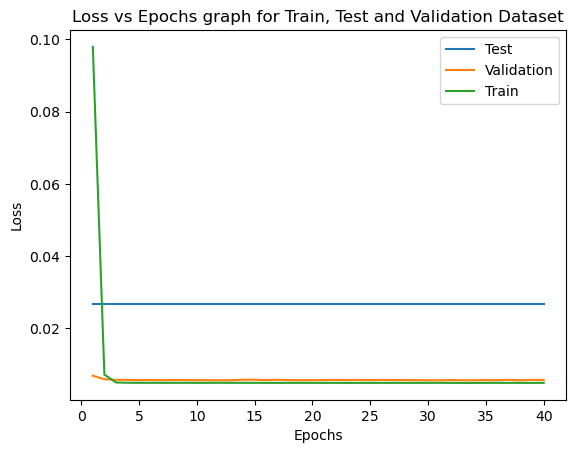

In [90]:
lstmAutoEncoderModel.plotLossVsEpochs()

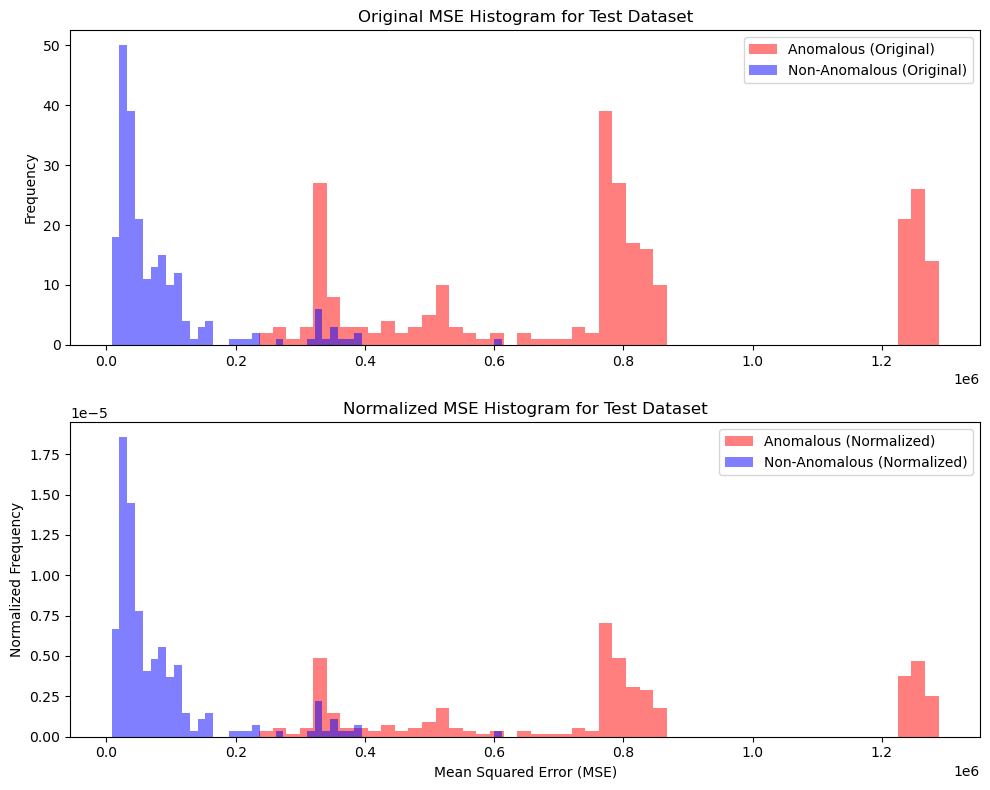

In [91]:
lstmAutoEncoderModel.plotTestDatasetMSEHistogram()

## LSTM - Dense Autoencoder 

In [59]:
lr=0.01
num_epochs = 40
l1_lambda = 0
l2_lambda = 0
early_stop = False
earlyStopPatience = 10
lr_scheduler = False
lrsPatience = 5
dropoutProb = 0
rnn_hidden_size = 4
hidden_size = 4
input_size = 1
threshold = thres
has_lstm = True
mincount = mincount
recurrentDropoutProb = 0
num_layers = 3
scaler = scaler
temp_model_path = 'content/autoencoder/denselstm_temp.pth'
final_model_path = 'content/autoencoder/denselstm.pth'
trial_save_path = 'content/autoencoder/denselstm.pkl'

In [60]:
class LSTMDenseAutoEncoder(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, windowlen, hidden_size, num_layers, dropout = 0, recurrent_dropout = 0):
        super(LSTMDenseAutoEncoder, self).__init__()
        
        self.lstmencoder = nn.LSTM(input_size=input_size, 
                               hidden_size=rnn_hidden_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)
        self.encoder = nn.Sequential(nn.Flatten(start_dim=1),
                        nn.Linear(windowlen*rnn_hidden_size, hidden_size*4),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(hidden_size*4, hidden_size),
                        nn.ReLU())
                        
        self.decoder = nn.Sequential(
                        nn.Linear(hidden_size, hidden_size*4),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(hidden_size*4, windowlen*rnn_hidden_size),
                        nn.Unflatten(dim=1, unflattened_size=torch.Size([windowlen, rnn_hidden_size])),
                        nn.ReLU())
        self.lstmdecoder = nn.LSTM(input_size=rnn_hidden_size, 
                               hidden_size=input_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)

    def forward(self, x):
        x, (_, _) = self.lstmencoder(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x, (_, _) = self.lstmdecoder(x)
        return x

In [61]:
lstmDenseAutoEncoder = LSTMDenseAutoEncoder(input_size=input_size,
                      hidden_size=hidden_size,
                      rnn_hidden_size=rnn_hidden_size,
                      windowlen = windowlen,
                      num_layers=num_layers,
                      dropout=dropoutProb,
                      recurrent_dropout=recurrentDropoutProb)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstmDenseAutoEncoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [62]:
lstmDenseAutoEncoderModel = ModelTrial(lstmDenseAutoEncoder, criterion, optimizer, threshold, mincount, scheduler = scheduler, scaler = scaler, l1_lambda = l1_lambda, has_lstm=has_lstm)

In [63]:
lstmDenseAutoEncoderModel.printModel()

LSTMDenseAutoEncoder(
  (lstmencoder): LSTM(1, 4, num_layers=3, batch_first=True)
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=16, bias=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=16, out_features=4, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=16, out_features=256, bias=True)
    (4): Unflatten(dim=1, unflattened_size=torch.Size([64, 4]))
    (5): ReLU()
  )
  (lstmdecoder): LSTM(4, 1, num_layers=3, batch_first=True)
)


In [64]:
lstmDenseAutoEncoderModel.printModelSummary((64, windowlen, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMDenseAutoEncoder                     [64, 64, 1]               --
├─LSTM: 1-1                              [64, 64, 4]               432
├─Sequential: 1-2                        [64, 4]                   --
│    └─Flatten: 2-1                      [64, 256]                 --
│    └─Linear: 2-2                       [64, 16]                  4,112
│    └─ReLU: 2-3                         [64, 16]                  --
│    └─Dropout: 2-4                      [64, 16]                  --
│    └─Linear: 2-5                       [64, 4]                   68
│    └─ReLU: 2-6                         [64, 4]                   --
├─Sequential: 1-3                        [64, 64, 4]               --
│    └─Linear: 2-7                       [64, 16]                  80
│    └─ReLU: 2-8                         [64, 16]                  --
│    └─Dropout: 2-9                      [64, 16]                  --
│    └─Line

In [65]:
lstmDenseAutoEncoderModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.98it/s]


Epoch 1, Training Loss: 0.00559


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 167.09it/s]


Epoch 1, Validation Loss: 0.00587
In Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.26it/s]


Epoch 2, Training Loss: 0.00496


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 177.73it/s]


Epoch 2, Validation Loss: 0.00570
In Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.80it/s]


Epoch 3, Training Loss: 0.00491


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 158.43it/s]


Epoch 3, Validation Loss: 0.00560
In Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.72it/s]


Epoch 4, Training Loss: 0.00488


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 168.50it/s]


Epoch 4, Validation Loss: 0.00561
In Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.32it/s]


Epoch 5, Training Loss: 0.00485


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 165.21it/s]


Epoch 5, Validation Loss: 0.00567
In Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.15it/s]


Epoch 6, Training Loss: 0.00485


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 191.82it/s]


Epoch 6, Validation Loss: 0.00564
In Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.85it/s]


Epoch 7, Training Loss: 0.00484


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 166.65it/s]


Epoch 7, Validation Loss: 0.00561
In Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.44it/s]


Epoch 8, Training Loss: 0.00484


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.56it/s]


Epoch 8, Validation Loss: 0.00555
In Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.92it/s]


Epoch 9, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 174.05it/s]


Epoch 9, Validation Loss: 0.00558
In Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.33it/s]


Epoch 10, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 189.51it/s]


Epoch 10, Validation Loss: 0.00559
In Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.75it/s]


Epoch 11, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.56it/s]


Epoch 11, Validation Loss: 0.00555
In Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.17it/s]


Epoch 12, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 186.52it/s]


Epoch 12, Validation Loss: 0.00557
In Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.62it/s]


Epoch 13, Training Loss: 0.00483


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 197.92it/s]


Epoch 13, Validation Loss: 0.00557
In Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.04it/s]


Epoch 14, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 186.25it/s]


Epoch 14, Validation Loss: 0.00553
In Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.42it/s]


Epoch 15, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 203.39it/s]


Epoch 15, Validation Loss: 0.00557
In Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.55it/s]


Epoch 16, Training Loss: 0.00483


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 178.65it/s]


Epoch 16, Validation Loss: 0.00554
In Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.21it/s]


Epoch 17, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 186.41it/s]


Epoch 17, Validation Loss: 0.00553
In Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.37it/s]


Epoch 18, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 188.06it/s]


Epoch 18, Validation Loss: 0.00566
In Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.28it/s]


Epoch 19, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 163.01it/s]


Epoch 19, Validation Loss: 0.00559
In Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.90it/s]


Epoch 20, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 152.02it/s]


Epoch 20, Validation Loss: 0.00562
In Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.27it/s]


Epoch 21, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.37it/s]


Epoch 21, Validation Loss: 0.00566
In Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.83it/s]


Epoch 22, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 169.69it/s]


Epoch 22, Validation Loss: 0.00560
In Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.16it/s]


Epoch 23, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 196.46it/s]


Epoch 23, Validation Loss: 0.00552
In Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.05it/s]


Epoch 24, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 179.17it/s]


Epoch 24, Validation Loss: 0.00561
In Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.06it/s]


Epoch 25, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.96it/s]


Epoch 25, Validation Loss: 0.00554
In Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.03it/s]


Epoch 26, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 183.20it/s]


Epoch 26, Validation Loss: 0.00564
In Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.44it/s]


Epoch 27, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 182.88it/s]


Epoch 27, Validation Loss: 0.00551
In Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.79it/s]


Epoch 28, Training Loss: 0.00482


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 190.74it/s]


Epoch 28, Validation Loss: 0.00558
In Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.03it/s]


Epoch 29, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 174.62it/s]


Epoch 29, Validation Loss: 0.00559
In Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.42it/s]


Epoch 30, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 187.77it/s]


Epoch 30, Validation Loss: 0.00553
In Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.14it/s]


Epoch 31, Training Loss: 0.00481


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 194.08it/s]


Epoch 31, Validation Loss: 0.00552
In Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.60it/s]


Epoch 32, Training Loss: 0.00480


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 174.19it/s]


Epoch 32, Validation Loss: 0.00562
In Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.34it/s]


Epoch 33, Training Loss: 0.00478


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 165.28it/s]


Epoch 33, Validation Loss: 0.00550
In Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.98it/s]


Epoch 34, Training Loss: 0.00478


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.40it/s]


Epoch 34, Validation Loss: 0.00575
In Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.53it/s]


Epoch 35, Training Loss: 0.00477


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 159.62it/s]


Epoch 35, Validation Loss: 0.00556
In Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.33it/s]


Epoch 36, Training Loss: 0.00477


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 157.11it/s]


Epoch 36, Validation Loss: 0.00554
In Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.21it/s]


Epoch 37, Training Loss: 0.00478


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 178.16it/s]


Epoch 37, Validation Loss: 0.00549
In Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.45it/s]


Epoch 38, Training Loss: 0.00475


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.69it/s]


Epoch 38, Validation Loss: 0.00556
In Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 31.23it/s]


Epoch 39, Training Loss: 0.00476


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 184.48it/s]


Epoch 39, Validation Loss: 0.00549
In Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.63it/s]


Epoch 40, Training Loss: 0.00476


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 175.13it/s]


Epoch 40, Validation Loss: 0.00549
Training Ended !!!


In [66]:
lstmDenseAutoEncoderModel.testDatasetPass(test_loader)

Testing Started!


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 119.84it/s]

Testing Completed!!
Testing Loss: 0.02624


In [67]:
lstmDenseAutoEncoderModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 0, Seconds: 30, Microseconds: 97131


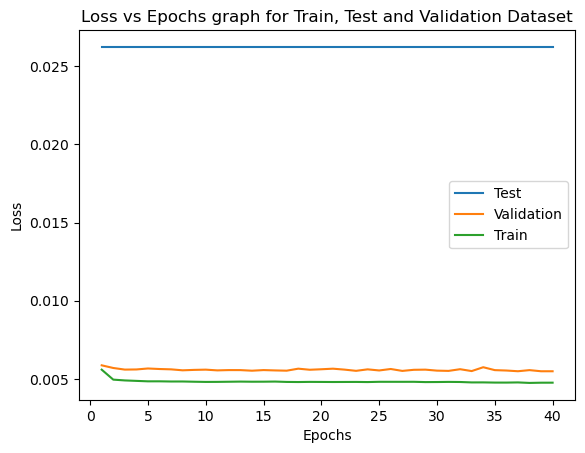

In [68]:
lstmDenseAutoEncoderModel.plotLossVsEpochs()

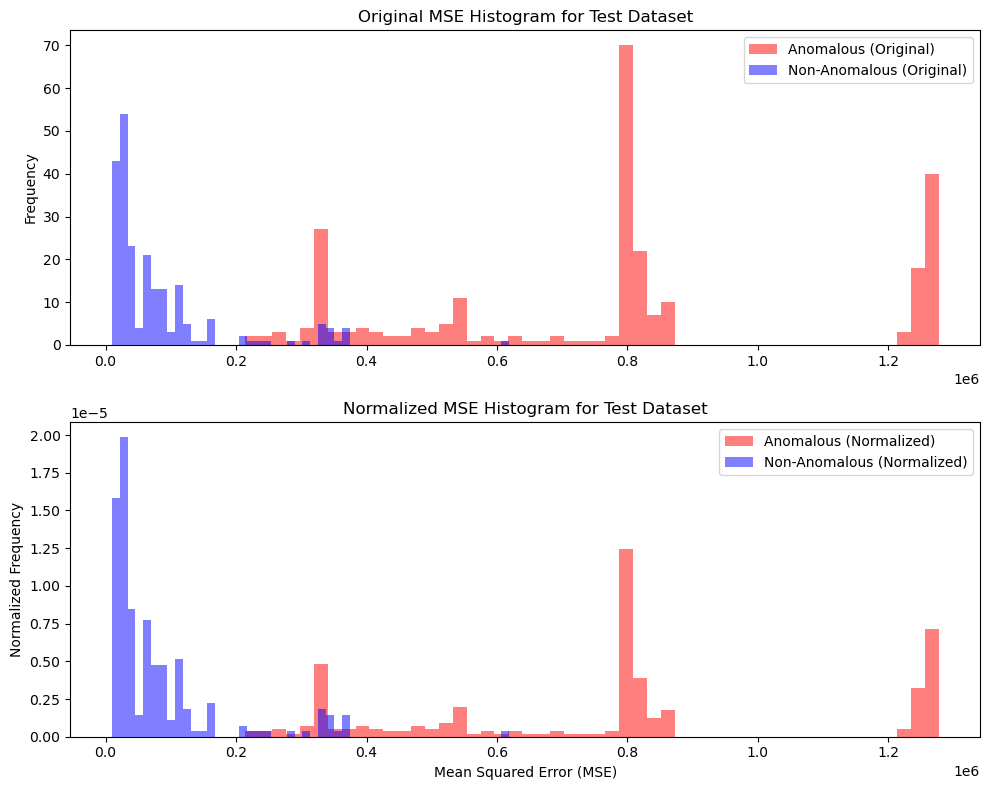

In [69]:
lstmDenseAutoEncoderModel.plotTestDatasetMSEHistogram()

## LSTM-Dense Autoencoder with hyperparameter tuning 

In [129]:
lr=0.01
num_epochs = 40
l1_lambda = 1e-5
l2_lambda = 1e-2
early_stop = True
earlyStopPatience = 10
lr_scheduler = True
lrsPatience = 5
dropoutProb = 0.2
rnn_hidden_size = 8
hidden_size = 8
input_size = 1
threshold = thres
has_lstm = True
mincount = mincount
recurrentDropoutProb = 0.2
num_layers = 5
scaler = scaler
temp_model_path = 'content/autoencoder/tuneddenselstm_temp.pth'
final_model_path = 'content/autoencoder/tuneddenselstm.pth'
trial_save_path = 'content/autoencoder/tuneddenselstm.pkl'

In [130]:
class TunedLSTMDenseAutoEncoder(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, windowlen, hidden_size, num_layers, dropout = 0, recurrent_dropout = 0):
        super(TunedLSTMDenseAutoEncoder, self).__init__()
        
        self.lstmencoder = nn.LSTM(input_size=input_size, 
                               hidden_size=rnn_hidden_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)
        self.encoder = nn.Sequential(nn.Flatten(start_dim=1),
                        nn.Linear(windowlen*rnn_hidden_size, hidden_size*16),
                        nn.Sigmoid(),
                        nn.Dropout(dropout),
                        nn.Linear(hidden_size*16, hidden_size),
                        nn.Sigmoid())
                        
        self.decoder = nn.Sequential(
                        nn.Linear(hidden_size, hidden_size*16),
                        nn.Sigmoid(),
                        nn.Dropout(dropout),
                        nn.Linear(hidden_size*16, windowlen*rnn_hidden_size),
                        nn.Unflatten(dim=1, unflattened_size=torch.Size([windowlen, rnn_hidden_size])),
                        nn.Sigmoid())
        self.lstmdecoder = nn.LSTM(input_size=rnn_hidden_size, 
                               hidden_size=input_size, 
                               num_layers=num_layers, 
                               batch_first=True,
                               dropout=recurrent_dropout)

    def forward(self, x):
        x, (_, _) = self.lstmencoder(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x, (_, _) = self.lstmdecoder(x)
        return x

In [131]:
tunedLstmDenseAutoEncoder = TunedLSTMDenseAutoEncoder(input_size=input_size,
                      hidden_size=hidden_size,
                      rnn_hidden_size=rnn_hidden_size,
                      windowlen = windowlen,
                      num_layers=num_layers,
                      dropout=dropoutProb,
                      recurrent_dropout=recurrentDropoutProb)
criterion = nn.MSELoss()
optimizer = optim.Adam(tunedLstmDenseAutoEncoder.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, threshold_mode = 'rel', mode = 'min', patience=lrsPatience, threshold=0.0001)

In [132]:
tunedLstmDenseAutoEncoderModel = ModelTrial(tunedLstmDenseAutoEncoder, criterion, optimizer, threshold, mincount, scheduler = scheduler, scaler = scaler, l1_lambda = l1_lambda, has_lstm=has_lstm)

In [133]:
tunedLstmDenseAutoEncoderModel.printModel()

TunedLSTMDenseAutoEncoder(
  (lstmencoder): LSTM(1, 8, num_layers=5, batch_first=True, dropout=0.2)
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): Sigmoid()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=8, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): Unflatten(dim=1, unflattened_size=torch.Size([64, 8]))
    (5): Sigmoid()
  )
  (lstmdecoder): LSTM(8, 1, num_layers=5, batch_first=True, dropout=0.2)
)


In [134]:
tunedLstmDenseAutoEncoderModel.printModelSummary((64, windowlen, 1))

Layer (type:depth-idx)                   Output Shape              Param #
TunedLSTMDenseAutoEncoder                [64, 64, 1]               --
├─LSTM: 1-1                              [64, 64, 8]               2,656
├─Sequential: 1-2                        [64, 8]                   --
│    └─Flatten: 2-1                      [64, 512]                 --
│    └─Linear: 2-2                       [64, 128]                 65,664
│    └─Sigmoid: 2-3                      [64, 128]                 --
│    └─Dropout: 2-4                      [64, 128]                 --
│    └─Linear: 2-5                       [64, 8]                   1,032
│    └─Sigmoid: 2-6                      [64, 8]                   --
├─Sequential: 1-3                        [64, 64, 8]               --
│    └─Linear: 2-7                       [64, 128]                 1,152
│    └─Sigmoid: 2-8                      [64, 128]                 --
│    └─Dropout: 2-9                      [64, 128]                 --
│ 

In [135]:
tunedLstmDenseAutoEncoderModel.trainingLoop(trainLoader = train_loader, validationLoader = valid_loader,
                         num_epochs = num_epochs,
                         temp_model_path = temp_model_path,
                         final_model_path = final_model_path,
                         trial_save_path = trial_save_path,
                         verbose = True, lr_scheduler = lr_scheduler,
                         early_stop = early_stop, patience = earlyStopPatience)

In Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.35it/s]


Epoch 1, Training Loss: 0.12056


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 106.78it/s]


Epoch 1, Validation Loss: 0.00578
In Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.64it/s]


Epoch 2, Training Loss: 0.01499


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 112.15it/s]


Epoch 2, Validation Loss: 0.00966
In Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 13.89it/s]


Epoch 3, Training Loss: 0.01211


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 109.06it/s]


Epoch 3, Validation Loss: 0.00626
In Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.51it/s]


Epoch 4, Training Loss: 0.01051


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 108.94it/s]


Epoch 4, Validation Loss: 0.00591
In Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.39it/s]


Epoch 5, Training Loss: 0.00990


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 122.05it/s]


Epoch 5, Validation Loss: 0.00599
In Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.43it/s]


Epoch 6, Training Loss: 0.00934


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 125.03it/s]


Epoch 6, Validation Loss: 0.00574
In Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.61it/s]


Epoch 7, Training Loss: 0.00887


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 127.24it/s]


Epoch 7, Validation Loss: 0.00572
In Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 13.59it/s]


Epoch 8, Training Loss: 0.00855


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 111.86it/s]


Epoch 8, Validation Loss: 0.00581
In Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.09it/s]


Epoch 9, Training Loss: 0.00827


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 98.85it/s]


Epoch 9, Validation Loss: 0.00579
In Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.27it/s]


Epoch 10, Training Loss: 0.00806


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 105.09it/s]


Epoch 10, Validation Loss: 0.00574
In Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.37it/s]


Epoch 11, Training Loss: 0.00786


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 112.46it/s]


Epoch 11, Validation Loss: 0.00566
In Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.84it/s]


Epoch 12, Training Loss: 0.00772


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 115.08it/s]


Epoch 12, Validation Loss: 0.00573
In Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.85it/s]


Epoch 13, Training Loss: 0.00761


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 94.60it/s]


Epoch 13, Validation Loss: 0.00565
In Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.76it/s]


Epoch 14, Training Loss: 0.00751


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 110.87it/s]


Epoch 14, Validation Loss: 0.00571
In Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.00it/s]


Epoch 15, Training Loss: 0.00741


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 93.33it/s]


Epoch 15, Validation Loss: 0.00565
In Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 11.11it/s]


Epoch 16, Training Loss: 0.00734


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 103.63it/s]


Epoch 16, Validation Loss: 0.00573
In Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.66it/s]


Epoch 17, Training Loss: 0.00728


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 123.41it/s]


Epoch 17, Validation Loss: 0.00579
In Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.94it/s]


Epoch 18, Training Loss: 0.00726


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 127.68it/s]


Epoch 18, Validation Loss: 0.00565
In Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.60it/s]


Epoch 19, Training Loss: 0.00721


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 126.45it/s]


Epoch 19, Validation Loss: 0.00566
In Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.93it/s]


Epoch 20, Training Loss: 0.00613


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 93.35it/s]


Epoch 20, Validation Loss: 0.00565
In Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.03it/s]


Epoch 21, Training Loss: 0.00565


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 114.66it/s]


Epoch 21, Validation Loss: 0.00569
In Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.34it/s]


Epoch 22, Training Loss: 0.00559


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 94.46it/s]


Epoch 22, Validation Loss: 0.00567
In Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.59it/s]


Epoch 23, Training Loss: 0.00556


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 125.93it/s]


Epoch 23, Validation Loss: 0.00565
In Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.51it/s]


Epoch 24, Training Loss: 0.00557


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 120.94it/s]


Epoch 24, Validation Loss: 0.00566
In Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.44it/s]


Epoch 25, Training Loss: 0.00556


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 129.70it/s]


Epoch 25, Validation Loss: 0.00568
In Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.31it/s]


Epoch 26, Training Loss: 0.00555


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 122.83it/s]


Epoch 26, Validation Loss: 0.00569
In Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.27it/s]


Epoch 27, Training Loss: 0.00548


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 119.56it/s]


Epoch 27, Validation Loss: 0.00566
In Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 11.15it/s]


Epoch 28, Training Loss: 0.00541


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 121.31it/s]


Epoch 28, Validation Loss: 0.00572
In Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.99it/s]


Epoch 29, Training Loss: 0.00540


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 119.55it/s]


Epoch 29, Validation Loss: 0.00568
In Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 10.89it/s]


Epoch 30, Training Loss: 0.00539


100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 128.02it/s]


Epoch 30, Validation Loss: 0.00577

Early stopping
Training Ended !!!


In [136]:
tunedLstmDenseAutoEncoderModel.testDatasetPass(test_loader)

Testing Started!


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 94.57it/s]

Testing Completed!!
Testing Loss: 0.02691


In [137]:
tunedLstmDenseAutoEncoderModel.printTrainTimeStatistics()

Time taken to train model (train phase alone considered) is : 
Days: 0, Hours: 0, Minutes: 1, Seconds: 0, Microseconds: 868437


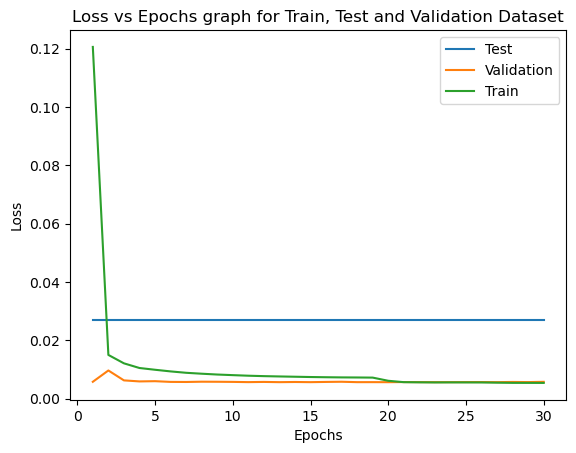

In [138]:
tunedLstmDenseAutoEncoderModel.plotLossVsEpochs()

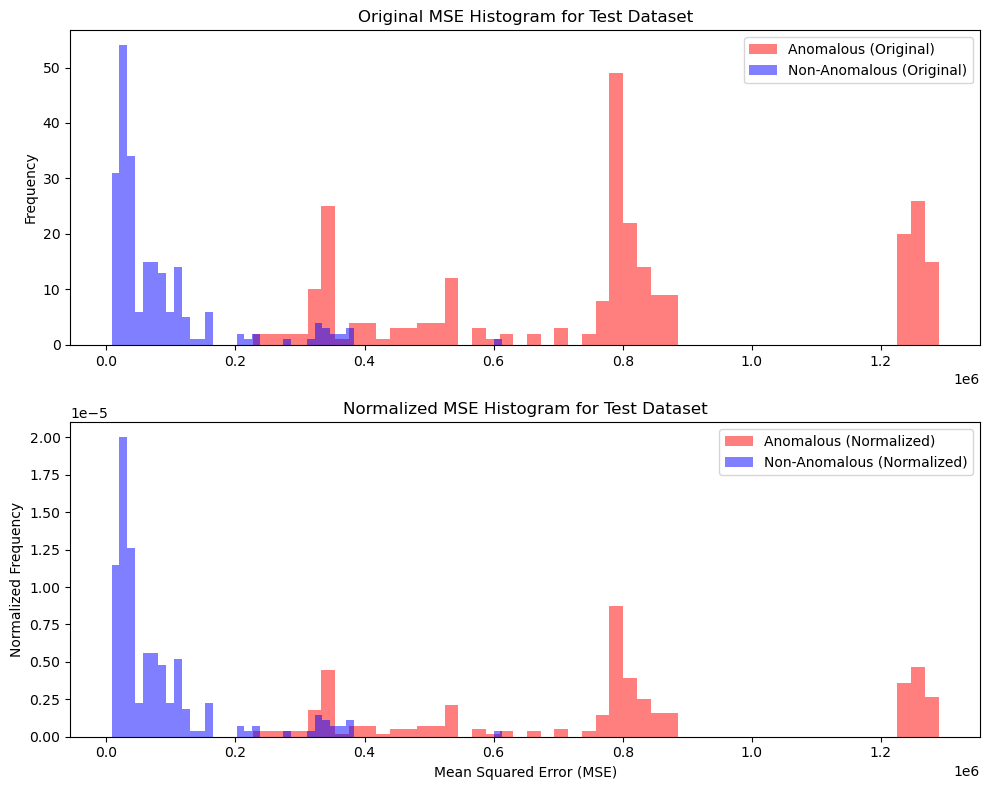

In [139]:
tunedLstmDenseAutoEncoderModel.plotTestDatasetMSEHistogram()

#### References
1.	https://docs.python.org/3/index.html

2.	https://matplotlib.org/stable/

3.	https://seaborn.pydata.org/api.html

4.	https://pandas.pydata.org/docs/reference/index.html

5.	https://numpy.org/doc/stable/index.html

6.	https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

7.	https://torchmetrics.readthedocs.io/en/stable/

8.	https://scikit-learn.org/stable/modules/classes.html

9.	https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_7_DeepLearning/Autoencoders.html

10.	https://pytorch.org/docs/stable/index.html

11.	https://github.com/TylerYep/torchinfo#readme